# 思路

## 模块提供的能力

**判断海报文字对齐的方式**

## 架构图

![framework](https://raw.githubusercontent.com/zhuojg/hacking-design-ai-2020/master/level02-3/images/framework.png)

## 实现思路

1. 使用模型识别文字位置，用一个矩形框来表示（矩形框由左上角和右下角2个顶点的坐标确定）
2. 计算各个框之间的对齐方式（水平和垂直）
3. 最后可视化输出对齐方式的占比

### 两个元素的对齐方式如何比较

* 左对齐：比较两个框左上顶点的横坐标  
* 右对齐：比较两个框右下顶点的横坐标  
* 垂直居中：比较两个框横坐标的均值  
* 顶部对齐：比较两个框左上顶点的纵坐标  
* 底部对齐：比较两个框右下顶点的纵坐标  
* 水平居中：比较两个框纵坐标的均值  

## 注意

运行text detection的代码需要下载模型  
链接：https://pan.baidu.com/s/1Tn_lFa5ePg7AwsixNVrCow   
提取码：atoy

In [40]:
# Lib import

import os
from PIL import Image
import cv2
from imutils.object_detection import non_max_suppression
import time
import numpy as np
import math
import matplotlib.pyplot as plt

In [59]:
# text detection
# code from 
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

def text_detection(img_path, width=320, height=320, min_confidence=0.5, show=False):
    # load the input image and grab the image dimensions
    image = cv2.imread(img_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    
    (newW, newH) = width, height
    rW = W / float(newW)
    rH = H / float(newH)
    
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    
    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet('./frozen_east_text_detection.pb')
    
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()
    
    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    true_boxes = []
    
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        
        true_boxes.append([startX, startY, endX, endY])

        # draw the bounding box on the image
        if show:
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    if show:
        plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return true_boxes

In [60]:
def aligned(x, y):
    if math.fabs(x - y) < 10:
        return True
    
    return False

In [61]:
# calculate alignment

def alignment_ratio(bb):
    left_align = 0
    right_align = 0
    center_align = 0
    
    top_align = 0
    bottom_align = 0
    middle_align = 0
    
    total_num = 0
    
    for i in range(len(bb)):
        startX_1 = bb[i][0]
        startY_1 = bb[i][1]
        endX_1 = bb[i][2]
        endY_1 = bb[i][3]
        for j in range(i + 1, len(bb)):
            total_num += 1
            
            startX_2 = bb[j][0]
            startY_2 = bb[j][1]
            endX_2 = bb[j][2]
            endY_2 = bb[j][3]
            
            if aligned(startX_1, startX_2):
                left_align += 1
            if aligned(endX_1, endX_2):
                right_align += 1
            if aligned((startX_1 + endX_1) / 2, (startX_2 + endX_2) / 2):
                center_align += 1
            
            if aligned(startY_1, startY_2):
                top_align += 1
            if aligned(endY_1, endY_2):
                bottom_align += 1
            if aligned((startY_1 + endY_1) / 2, (startY_2 + endY_2) / 2):
                middle_align += 1
            
    vertial_align = left_align + right_align + center_align
    horizontal_align = top_align + bottom_align + middle_align
    
    return left_align, right_align, center_align, top_align, bottom_align, middle_align

# show the ratio
#     print('left: %s' % (left_align / total_num))
#     print('right: %s' % (right_align / total_num))
#     print('center: %s' % (center_align / total_num))
    
#     print('top: %s' % (top_align / total_num))
#     print('bottom: %s' % (bottom_align / total_num))
#     print('middle: %s' % (middle_align / total_num))
    
#     print('left: %s' % (left_align / vertial_align))
#     print('right: %s' % (right_align / vertial_align))
#     print('center: %s' % (center_align / vertial_align))
    
#     print('top: %s' % (top_align / horizontal_align))
#     print('bottom: %s' % (bottom_align / horizontal_align))
#     print('middle: %s' % (middle_align / horizontal_align))

[INFO] loading EAST text detector...
[INFO] text detection took 0.180964 seconds


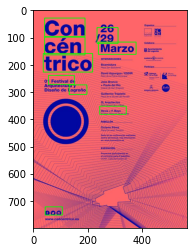

In [62]:
boundary_boxes = text_detection('test-2.jpg', show=True)
left, right, center, top, bottom, middle = alignment_ratio(boundary_boxes)

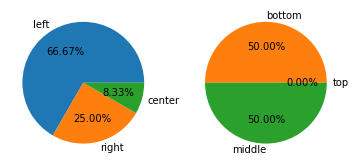

In [63]:
# visualise the result

plt.figure(facecolor='white', edgecolor='black')
plt.subplot(1, 2, 1)
plt.pie([left, right, center], labels=['left', 'right', 'center'], autopct='%3.2f%%')
plt.subplot(1, 2, 2)
plt.pie([top, bottom, middle], labels=['top', 'bottom', 'middle'], autopct='%3.2f%%')
plt.show()